In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Device 세팅

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'mps':
    torch.mps.manual_seed(1)

print(device)

mps


### 모델 및 학습 정의

In [3]:
DROP_OUT_R = 0.5
LEARNING_RATE = 0.001

EPOCHS = 500
BATCH_SIZE = 50
#VALIDATION_RATE = 0.1

CHECK_INTERVAL = 10
# EARLY_STOP = 30

In [4]:
MC_FNN_40N = nn.Sequential(
    nn.Linear(30,40),
    nn.Dropout(DROP_OUT_R),
    nn.LeakyReLU(),
    nn.Linear(40,1),
    nn.LeakyReLU()
).to(device)

In [5]:
# 파라미터 개수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(MC_FNN_40N)) #사용

1281


In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(MC_FNN_40N.parameters(), lr=LEARNING_RATE)

### 학습 과정 정의

In [7]:
train_losses = []

In [8]:
def train_model(train_loader, epochs, check_interval):
    
    for e in range(epochs):
        train_loss = 0
        
        MC_FNN_40N.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred_y = MC_FNN_40N(x_batch)
            loss = loss_func(pred_y, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            train_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        train_losses.append(train_loss)
        
        if (e % check_interval) == 0:
            print("epoch : ", e, "train loss: ",train_losses[-1])

### Custom Dataset Type 정의

In [9]:
class BAT_DATASET(Dataset):
    def __init__(self, X, y):
        super().__init__()
        X = deepcopy(X)
        y = deepcopy(y)
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, index):
        rX = self.X[index]
        ry = self.y[index]

        return rX, ry
        

### 데이터 묶기 (10개씩)

In [10]:
def prepareXY(X_ndArray, y_ndArray):
   X_data = list()

   for idx in range(0,len(X_ndArray), 10):
      X_data.append(X_ndArray[idx: idx+10].reshape(-1,30))

   X_data = np.array(X_data)

   return X_data, y_ndArray

### ----- ⚠️ 파라미터 불러오기 ------------------------

params = torch.load("../BEST_MODEL/MC_FNN_40N_params.pt")
MC_FNN_40N.load_state_dict(params)

### ----- B0006/B0007/B00018 데이터 학습 ------

In [13]:
def all_data_train_wrapper():
    data_file_indices = ["B0006", "B0007", "B0018"]

    for d_idx in data_file_indices: 
        
        x_df = pd.read_csv(f"../DATA/DataFrame/{d_idx}_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
        y_df = pd.read_csv(f"../DATA/DataFrame/{d_idx}_capacity_df.csv").loc[:,["capacity"]]

        x_df_10points = pd.DataFrame(columns=x_df.columns)

        for cyc in x_df["cycle"].unique():
            tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
            interval = len(tmp_cycle_x_df.index)//10
            choosed_idx = []
            for idx in range(0,len(tmp_cycle_x_df), interval):
                if len(choosed_idx) == 10 :
                        break
                choosed_idx.append(idx)

            x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)

        
        display(x_df_10points)

        X_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaler = MinMaxScaler(feature_range=(0,1))

        RAW_XDATA = deepcopy(x_df_10points)
        RAW_yDATA = deepcopy(y_df)

        X_scaled = X_scaler.fit_transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
        y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))

        X_data, y_data= prepareXY(X_scaled, y_scaled)
        X_data = torch.from_numpy(X_data).type(torch.float).reshape(-1,30)
        y_data = torch.from_numpy(y_data).type(torch.float)

        train_dataset = BAT_DATASET(X_data, y_data)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=False)

        train_model(train_loader, EPOCHS, CHECK_INTERVAL)

In [14]:
all_data_train_wrapper()

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.320249,1.515595,31.861155,5.500
76,2,3.772765,1.513079,29.518580,234.078
152,2,3.869867,1.512962,28.012962,511.156
228,2,3.928052,1.515339,27.151827,875.062
304,2,3.968767,1.513685,26.699932,1364.266
...,...,...,...,...,...
375596,169,4.198806,0.349829,25.757573,3460.406
375852,169,4.199172,0.246677,24.935181,4206.797
376108,169,4.199734,0.176216,24.455348,4952.406
376364,169,4.199159,0.129508,24.188771,5697.531


epoch :  0 train loss:  0.19386622740421444
epoch :  10 train loss:  0.07439903635531664
epoch :  20 train loss:  0.03844557795673609
epoch :  30 train loss:  0.031273878645151854
epoch :  40 train loss:  0.024053068249486387
epoch :  50 train loss:  0.021378290373831987
epoch :  60 train loss:  0.018929434474557638
epoch :  70 train loss:  0.01849880674853921
epoch :  80 train loss:  0.013436009816359729
epoch :  90 train loss:  0.012618556793313473
epoch :  100 train loss:  0.014475308649707586
epoch :  110 train loss:  0.01292662846390158
epoch :  120 train loss:  0.011543169559445232
epoch :  130 train loss:  0.00992919085547328
epoch :  140 train loss:  0.010123291984200478
epoch :  150 train loss:  0.007757268351269886
epoch :  160 train loss:  0.007517902180552483
epoch :  170 train loss:  0.008412082999711856
epoch :  180 train loss:  0.007604292390169576
epoch :  190 train loss:  0.009315933071775362
epoch :  200 train loss:  0.009682490810519084
epoch :  210 train loss:  0.00

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.270404,1.491025,30.573112,5.500
76,2,3.785553,1.491617,28.583428,234.078
152,2,3.881019,1.490421,27.391036,511.156
228,2,3.937696,1.491074,26.781612,875.062
304,2,3.978918,1.490915,26.575697,1364.266
...,...,...,...,...,...
375596,169,4.211561,0.512472,26.321016,3460.406
375852,169,4.212398,0.330517,25.159387,4206.797
376108,169,4.213197,0.224771,24.448661,4952.406
376364,169,4.211974,0.149447,24.056267,5697.531


epoch :  0 train loss:  0.04173867776989937
epoch :  10 train loss:  0.012956445221789181
epoch :  20 train loss:  0.009182006207993254
epoch :  30 train loss:  0.010154793853871524
epoch :  40 train loss:  0.009609784057829529
epoch :  50 train loss:  0.010311715013813227
epoch :  60 train loss:  0.00954836915479973
epoch :  70 train loss:  0.008483837766107172
epoch :  80 train loss:  0.008937928709201515
epoch :  90 train loss:  0.008494443813106045
epoch :  100 train loss:  0.007836677716113627
epoch :  110 train loss:  0.007593902439111844
epoch :  120 train loss:  0.008826313220197335
epoch :  130 train loss:  0.008856418280629441
epoch :  140 train loss:  0.008201225922675803
epoch :  150 train loss:  0.007418674533255398
epoch :  160 train loss:  0.009810450777877122
epoch :  170 train loss:  0.008804446639260277
epoch :  180 train loss:  0.0067738142679445446
epoch :  190 train loss:  0.009399857430253178
epoch :  200 train loss:  0.007379333808785304
epoch :  210 train loss: 

,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.479525,1.515638,24.286875,5.219
257,2,3.938450,1.516332,24.243205,653.547
514,2,3.997673,1.515629,25.168382,1303.219
771,2,4.049742,1.515579,26.206501,1952.907
1028,2,4.124331,1.517625,27.305446,2602.360
...,...,...,...,...,...
190602,134,4.198443,0.425873,25.797876,3527.000
190702,134,4.198810,0.274652,24.716367,4252.766
190802,134,4.200036,0.192107,24.088869,4977.859
190902,134,4.199606,0.136557,23.701478,5706.000


epoch :  0 train loss:  0.023339352880915005
epoch :  10 train loss:  0.010288322033981482
epoch :  20 train loss:  0.009996999986469746
epoch :  30 train loss:  0.00981970209007462
epoch :  40 train loss:  0.0078030166526635485
epoch :  50 train loss:  0.008275182296832403
epoch :  60 train loss:  0.008583820269753536
epoch :  70 train loss:  0.009741132147610188
epoch :  80 train loss:  0.005761599168181419
epoch :  90 train loss:  0.00719891410941879
epoch :  100 train loss:  0.00710785078505675
epoch :  110 train loss:  0.00660852746417125
epoch :  120 train loss:  0.007502642072116335
epoch :  130 train loss:  0.0072193042530367775
epoch :  140 train loss:  0.006488247774541378
epoch :  150 train loss:  0.007090535402918856
epoch :  160 train loss:  0.00660452696805199
epoch :  170 train loss:  0.007209096724788348
epoch :  180 train loss:  0.008856788355236253
epoch :  190 train loss:  0.008419727596143881
epoch :  200 train loss:  0.006725043446446459
epoch :  210 train loss:  0

### ----- ⚠️ 새로운 파라미터 저장 ------------------------

MC_FNN_40N_params = MC_FNN_40N.state_dict()
torch.save(MC_FNN_40N_params, "../BEST_MODEL/MC_FNN_40N_params.pt")

### B0005 예측

In [17]:
x_df = pd.read_csv(f"../DATA/DataFrame/B0005_charge_df.csv").loc[:,["cycle", "voltage_measured", "current_measured", "temperature_measured", "time"]]
y_df = pd.read_csv(f"../DATA/DataFrame/B0005_capacity_df.csv").loc[:,["capacity"]]

x_df_10points = pd.DataFrame(columns=x_df.columns)
for cyc in x_df["cycle"].unique():
    tmp_cycle_x_df = x_df[x_df["cycle"] == cyc]
    interval = len(tmp_cycle_x_df.index)//10
    choosed_idx = []
    for idx in range(0,len(tmp_cycle_x_df), interval):
        if len(choosed_idx) == 10 :
            break
        choosed_idx.append(idx)

    x_df_10points = pd.concat([x_df_10points, tmp_cycle_x_df.iloc[choosed_idx]], axis=0)    
display(x_df_10points)

X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

RAW_XDATA = deepcopy(x_df_10points)
RAW_yDATA = deepcopy(y_df)

X_scaled = X_scaler.fit_transform(RAW_XDATA[["voltage_measured", "current_measured", "temperature_measured"]].values.reshape(-1,3))
y_scaled = y_scaler.fit_transform(RAW_yDATA["capacity"].unique().reshape(-1,1))
        
X_data, y_data= prepareXY(X_scaled, y_scaled)
X_data = torch.from_numpy(X_data).type(torch.float).reshape(-1,30)
y_data = torch.from_numpy(y_data).type(torch.float)

test_dataset = BAT_DATASET(X_data, y_data)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

predicts = []

MC_FNN_40N.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
            
        pred_y = MC_FNN_40N(x_batch)

        predicts.append(pred_y.to('cpu'))

predicts_concat = torch.cat(predicts, 0)
predicts_df = pd.DataFrame(y_scaler.inverse_transform(np.array(predicts_concat)))


,cycle,voltage_measured,current_measured,temperature_measured,time
0,2,3.434644,1.508670,29.334717,5.500
76,2,3.814079,1.510073,27.739727,234.078
152,2,3.881686,1.509227,26.890304,511.156
228,2,3.937241,1.508747,26.481944,875.062
304,2,3.979605,1.506559,26.476934,1364.266
...,...,...,...,...,...
375596,169,4.205285,0.409958,26.151950,3460.406
375852,169,4.205106,0.261199,25.147212,4206.797
376108,169,4.204985,0.184375,24.550544,4952.406
376364,169,4.206357,0.135819,24.199547,5697.531


In [18]:
predicts_df

,0
0,1.824623
1,1.819903
2,1.823196
3,1.822942
4,1.828378
...,...
162,1.280734
163,1.280640
164,1.280468
165,1.280452


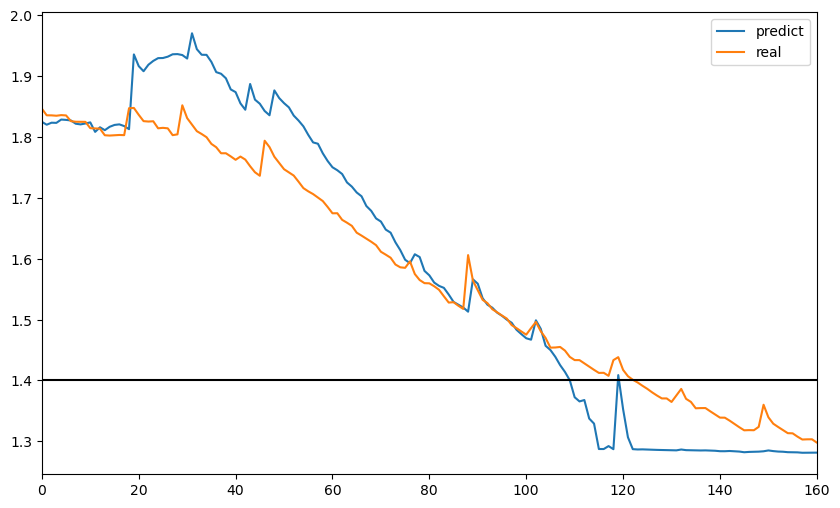

In [19]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.xlim([0, 160])

plt.plot(predicts_df.index, predicts_df.iloc[:,0], label='predict')
plt.plot(range(len(y_df.index)), y_df.iloc[:,0], label='real')
plt.plot(range(len(y_df.index)), [1.4 for i in range(len(y_df.index))], color='black')

plt.legend()
plt.show()

predicts_df.to_csv("../PREDICT/MC_FNN_40N.csv", index = False)